# Self-supervised Learning with MoCo on EuroSAT
In this notebook, we will pretrain a ResNet18 model on EuroSAT dataset using MoCo, and visualize the learned representations with t-SNE.

[MoCo](https://arxiv.org/abs/1911.05722) (Momentum Contrast) is one representative contrastive self-supervised learning method that trains a visual encoder by matching an encoded query q to a dictionary of encoded keys using a contrastive loss.

[EuroSAT](https://github.com/phelber/EuroSAT) is a popular CIFAR10-like remote sensing dataset that consists of 27,000 Sentinel-2 images, which are labeled by 10 land cover land use classes.

[t-SNE](https://www.jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf?fbcl) (t-distributed stochastic neighbor embedding) is a statistical method for visualizing high-dimensional data by giving each datapoint a location in a two or three-dimensional map.

### Import modules

In [1]:
from datetime import datetime
from functools import partial
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader,Subset
from torchvision import transforms
from torchvision.models import resnet
import torchvision
from tqdm import tqdm
import argparse
import json
import math
import os
import pandas as pd
import numpy as np
import zipfile
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import time

device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [2]:
#!nvidia-smi -i 0

### Prepare EuroSAT dataset

Download and extract the dataset

In [3]:
!wget https://zenodo.org/records/7711810/files/EuroSAT_RGB.zip?download=1 --output-document EuroSAT_RGB.zip

--2023-11-09 12:50:33--  https://zenodo.org/records/7711810/files/EuroSAT_RGB.zip?download=1
Resolving zenodo.org (zenodo.org)... 188.185.22.33, 188.185.33.206, 188.185.10.78, ...
Connecting to zenodo.org (zenodo.org)|188.185.22.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 94658721 (90M) [application/octet-stream]
Saving to: 'EuroSAT_RGB.zip'

100%[======================================>] 94,658,721  9.82MB/s   in 7.7s   

2023-11-09 12:50:41 (11.8 MB/s) - 'EuroSAT_RGB.zip' saved [94658721/94658721]



In [4]:
with zipfile.ZipFile('EuroSAT_RGB.zip', 'r') as zip_ref:
    zip_ref.extractall('EuroSAT')

Split into train/test sets

In [5]:
#!pip install split-folders
import splitfolders
splitfolders.ratio('EuroSAT/EuroSAT_RGB', output="EuroSAT/EuroSAT_RGB_train_test", seed=42, ratio=(.8, 0,0.2)) # 21600 train, 5400 test

Copying files: 27000 files [00:30, 885.43 files/s] 


### Define arguments

In [35]:
parser = argparse.ArgumentParser(description='Train MoCo on EuroSAT')

parser.add_argument('-a', '--arch', default='resnet18')

# lr: 0.06 for batch 512 (or 0.03 for batch 256)
parser.add_argument('--lr', '--learning-rate', default=0.06, type=float, metavar='LR', help='initial learning rate', dest='lr')
parser.add_argument('--epochs', default=200, type=int, metavar='N', help='number of total epochs to run')
parser.add_argument('--schedule', default=[120, 160], nargs='*', type=int, help='learning rate schedule (when to drop lr by 10x); does not take effect if --cos is on')
parser.add_argument('--cos', action='store_true', help='use cosine lr schedule')

parser.add_argument('--batch-size', default=512, type=int, metavar='N', help='mini-batch size')
parser.add_argument('--wd', default=5e-4, type=float, metavar='W', help='weight decay')

# moco specific configs:
parser.add_argument('--moco-dim', default=128, type=int, help='feature dimension')
parser.add_argument('--moco-k', default=4096, type=int, help='queue size; number of negative keys')
parser.add_argument('--moco-m', default=0.99, type=float, help='moco momentum of updating key encoder')
parser.add_argument('--moco-t', default=0.1, type=float, help='softmax temperature')

parser.add_argument('--bn-splits', default=8, type=int, help='simulate multi-gpu behavior of BatchNorm in one gpu; 1 is SyncBatchNorm in multi-gpu')

parser.add_argument('--symmetric', action='store_true', help='use a symmetric loss function that backprops to both crops')

# knn monitor
parser.add_argument('--knn-k', default=200, type=int, help='k in kNN monitor')
parser.add_argument('--knn-t', default=0.1, type=float, help='softmax temperature in kNN monitor; could be different with moco-t')

# utils
parser.add_argument('--resume', default='', type=str, metavar='PATH', help='path to latest checkpoint (default: none)')
parser.add_argument('--results-dir', default='', type=str, metavar='PATH', help='path to cache (default: none)')


'''
args = parser.parse_args()  # running in command line
'''
args = parser.parse_args('')  # running in ipynb

# set command line arguments here when running in ipynb
args.epochs = 100
args.cos = True
args.schedule = []  # cos in use
args.symmetric = False
args.batch_size = 256
args.bn_splits = 4
args.lr = 0.2


if args.results_dir == '':
    args.results_dir = './results/cache-' + datetime.now().strftime("%Y-%m-%d-%H-%M-%S-moco")
    os.makedirs(args.results_dir)


print(args)

Namespace(arch='resnet18', lr=0.2, epochs=100, schedule=[], cos=True, batch_size=256, wd=0.0005, moco_dim=128, moco_k=4096, moco_m=0.99, moco_t=0.1, bn_splits=4, symmetric=False, knn_k=200, knn_t=0.1, resume='', results_dir='./results/cache-2023-11-09-12-58-23-moco')


### Dataset and DataLoader

In [33]:
class TwoCropsTransform:
    """Take two random crops of one image as the query and key."""

    def __init__(self, base_transform):
        self.base_transform = base_transform

    def __call__(self, x):
        q = self.base_transform(x)
        k = self.base_transform(x)
        return [q, k]

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(56,scale=(0.2,1.0)),
    transforms.RandomApply([transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    #transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])
    ])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])
    ])

# Load data
train_dataset = torchvision.datasets.ImageFolder(root='EuroSAT/EuroSAT_RGB_train_test/train',transform=TwoCropsTransform(train_transform))
test_dataset = torchvision.datasets.ImageFolder(root='EuroSAT/EuroSAT_RGB_train_test/test',transform=test_transform)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True, num_workers=4, pin_memory=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=args.batch_size, shuffle=False, num_workers=4, pin_memory=True)

print(len(train_dataset),len(test_dataset))


21600 5400


Visualize an example image

label: AnnualCrop


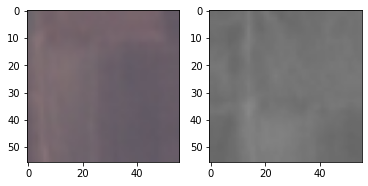

In [9]:
(img1, img2), label = train_dataset[0]
plt.subplot(1,2,1)
plt.imshow(img1.permute(1,2,0))
plt.subplot(1,2,2)
plt.imshow(img2.permute(1,2,0))
print("label:",train_dataset.classes[label])

### Build model

Define basic encoder

In [10]:
# SplitBatchNorm: simulate multi-gpu behavior of BatchNorm in one gpu by splitting along the batch dimension
# implementation adapted from https://github.com/davidcpage/cifar10-fast/blob/master/torch_backend.py
class SplitBatchNorm(nn.BatchNorm2d):
    def __init__(self, num_features, num_splits, **kw):
        super().__init__(num_features, **kw)
        self.num_splits = num_splits

    def forward(self, input):
        N, C, H, W = input.shape
        if self.training or not self.track_running_stats:
            running_mean_split = self.running_mean.repeat(self.num_splits)
            running_var_split = self.running_var.repeat(self.num_splits)
            outcome = nn.functional.batch_norm(
                input.view(-1, C * self.num_splits, H, W), running_mean_split, running_var_split,
                self.weight.repeat(self.num_splits), self.bias.repeat(self.num_splits),
                True, self.momentum, self.eps).view(N, C, H, W)
            self.running_mean.data.copy_(running_mean_split.view(self.num_splits, C).mean(dim=0))
            self.running_var.data.copy_(running_var_split.view(self.num_splits, C).mean(dim=0))
            return outcome
        else:
            return nn.functional.batch_norm(
                input, self.running_mean, self.running_var,
                self.weight, self.bias, False, self.momentum, self.eps)

class ModelBase(nn.Module):
    """
    Common CIFAR ResNet recipe.
    Comparing with ImageNet ResNet recipe, it:
    (i) replaces conv1 with kernel=3, str=1
    (ii) removes pool1
    """
    def __init__(self, feature_dim=128, arch=None, bn_splits=16):
        super(ModelBase, self).__init__()

        # use split batchnorm
        norm_layer = partial(SplitBatchNorm, num_splits=bn_splits) if bn_splits > 1 else nn.BatchNorm2d
        resnet_arch = getattr(resnet, arch)
        net = resnet_arch(num_classes=feature_dim, norm_layer=norm_layer)

        self.net = []
        for name, module in net.named_children():
            if name == 'conv1':
                module = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
            if isinstance(module, nn.MaxPool2d):
                continue
            if isinstance(module, nn.Linear):
                self.net.append(nn.Flatten(1))
            self.net.append(module)

        self.net = nn.Sequential(*self.net)

    def forward(self, x):
        x = self.net(x)
        # note: not normalized here
        return x

Build MoCo model

In [36]:
class ModelMoCo(nn.Module):
    def __init__(self, dim=128, K=4096, m=0.99, T=0.1, arch='resnet18', bn_splits=8, symmetric=True):
        super(ModelMoCo, self).__init__()

        self.K = K
        self.m = m
        self.T = T
        self.symmetric = symmetric

        # create the encoders
        self.encoder_q = ModelBase(feature_dim=dim, arch=arch, bn_splits=bn_splits)
        self.encoder_k = ModelBase(feature_dim=dim, arch=arch, bn_splits=bn_splits)

        for param_q, param_k in zip(self.encoder_q.parameters(), self.encoder_k.parameters()):
            param_k.data.copy_(param_q.data)  # initialize
            param_k.requires_grad = False  # not update by gradient

        # create the queue
        self.register_buffer("queue", torch.randn(dim, K))
        self.queue = nn.functional.normalize(self.queue, dim=0)

        self.register_buffer("queue_ptr", torch.zeros(1, dtype=torch.long))

    @torch.no_grad()
    def _momentum_update_key_encoder(self):
        """
        Momentum update of the key encoder
        """
        for param_q, param_k in zip(self.encoder_q.parameters(), self.encoder_k.parameters()):
            param_k.data = param_k.data * self.m + param_q.data * (1. - self.m)

    @torch.no_grad()
    def _dequeue_and_enqueue(self, keys):
        batch_size = keys.shape[0]

        ptr = int(self.queue_ptr)
        assert self.K % batch_size == 0  # for simplicity

        # replace the keys at ptr (dequeue and enqueue)
        self.queue[:, ptr:ptr + batch_size] = keys.t()  # transpose
        ptr = (ptr + batch_size) % self.K  # move pointer

        self.queue_ptr[0] = ptr

    @torch.no_grad()
    def _batch_shuffle_single_gpu(self, x):
        """
        Batch shuffle, for making use of BatchNorm.
        """
        # random shuffle index
        idx_shuffle = torch.randperm(x.shape[0]).to(device)

        # index for restoring
        idx_unshuffle = torch.argsort(idx_shuffle)

        return x[idx_shuffle], idx_unshuffle

    @torch.no_grad()
    def _batch_unshuffle_single_gpu(self, x, idx_unshuffle):
        """
        Undo batch shuffle.
        """
        return x[idx_unshuffle]

    def contrastive_loss(self, im_q, im_k):
        # compute query features
        q = self.encoder_q(im_q)  # queries: NxC
        q = nn.functional.normalize(q, dim=1)  # already normalized

        # compute key features
        with torch.no_grad():  # no gradient to keys
            # shuffle for making use of BN
            im_k_, idx_unshuffle = self._batch_shuffle_single_gpu(im_k)

            k = self.encoder_k(im_k_)  # keys: NxC
            k = nn.functional.normalize(k, dim=1)  # already normalized

            # undo shuffle
            k = self._batch_unshuffle_single_gpu(k, idx_unshuffle)

        # compute logits
        # Einstein sum is more intuitive
        # positive logits: Nx1
        l_pos = torch.einsum('nc,nc->n', [q, k]).unsqueeze(-1)
        # negative logits: NxK
        l_neg = torch.einsum('nc,ck->nk', [q, self.queue.clone().detach()])

        # logits: Nx(1+K)
        logits = torch.cat([l_pos, l_neg], dim=1)

        # apply temperature
        logits /= self.T

        # labels: positive key indicators
        labels = torch.zeros(logits.shape[0], dtype=torch.long).to(device)

        loss = nn.CrossEntropyLoss().to(device)(logits, labels)

        return loss, q, k

    def forward(self, im1, im2):
        """
        Input:
            im_q: a batch of query images
            im_k: a batch of key images
        Output:
            loss
        """

        # update the key encoder
        with torch.no_grad():  # no gradient to keys
            self._momentum_update_key_encoder()

        # compute loss
        if self.symmetric:  # asymmetric loss
            loss_12, q1, k2 = self.contrastive_loss(im1, im2)
            loss_21, q2, k1 = self.contrastive_loss(im2, im1)
            loss = loss_12 + loss_21
            k = torch.cat([k1, k2], dim=0)
        else:  # asymmetric loss
            loss, q, k = self.contrastive_loss(im1, im2)

        self._dequeue_and_enqueue(k)

        return loss

# create model
model = ModelMoCo(
        dim=args.moco_dim,
        K=args.moco_k,
        m=args.moco_m,
        T=args.moco_t,
        arch=args.arch,
        bn_splits=args.bn_splits,
        symmetric=args.symmetric,
    ).to(device)
print(model.encoder_q)

ModelBase(
  (net): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): SplitBatchNorm(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): SplitBatchNorm(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): SplitBatchNorm(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): SplitBatchNorm(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel

## Stage 1: self-supervised pretraining

### Define training process

In [12]:
# train for one epoch
def train(net, data_loader, train_optimizer, epoch, args):
    net.train()
    adjust_learning_rate(train_optimizer, epoch, args)

    total_loss, total_num, train_bar = 0.0, 0, tqdm(data_loader)
    for [im_1, im_2],_ in train_bar:
        im_1, im_2 = im_1.to(device), im_2.to(device)

        loss = net(im_1, im_2)

        train_optimizer.zero_grad()
        loss.backward()
        train_optimizer.step()

        total_num += data_loader.batch_size
        total_loss += loss.item() * data_loader.batch_size
        train_bar.set_description('Train Epoch: [{}/{}], lr: {:.6f}, Loss: {:.4f}'.format(epoch, args.epochs, train_optimizer.param_groups[0]['lr'], total_loss / total_num))

    return total_loss / total_num

# lr scheduler for training
def adjust_learning_rate(optimizer, epoch, args):
    """Decay the learning rate based on schedule"""
    lr = args.lr
    if args.cos:  # cosine lr schedule
        lr *= 0.5 * (1. + math.cos(math.pi * epoch / args.epochs))
    else:  # stepwise lr schedule
        for milestone in args.schedule:
            lr *= 0.1 if epoch >= milestone else 1.
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

### Start training

(optionally) Download our trained 100 epoch's checkpoint to save time

In [13]:
!wget https://huggingface.co/wangyi111/waw_wsl4eo/resolve/main/moco_eurosat_rn18_ep100.pth -O results/model_ep100.pth

--2023-11-09 12:52:12--  https://huggingface.co/wangyi111/waw_wsl4eo/resolve/main/moco_eurosat_rn18_ep100.pth
Resolving huggingface.co (huggingface.co)... 18.64.79.71, 18.64.79.120, 18.64.79.123, ...
Connecting to huggingface.co (huggingface.co)|18.64.79.71|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs-us-1.huggingface.co/repos/78/e7/78e72d9cf7ecf5762d8ccd271bb99315d24fa53b04966c4efe3cd444d4242466/c0c77c989bee4860e12d70746b6db5d04a854efbc5174688cbae33af9e38a135?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27moco_eurosat_rn18_ep100.pth%3B+filename%3D%22moco_eurosat_rn18_ep100.pth%22%3B&Expires=1699789932&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTY5OTc4OTkzMn19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy11cy0xLmh1Z2dpbmdmYWNlLmNvL3JlcG9zLzc4L2U3Lzc4ZTcyZDljZjdlY2Y1NzYyZDhjY2QyNzFiYjk5MzE1ZDI0ZmE1M2IwNDk2NmM0ZWZlM2NkNDQ0ZDQyNDI0NjYvYzBjNzdjOTg5YmVlNDg2MGUxMmQ3MDc0NmI2ZGI1ZDA0YTg1NG

Train another one epoch for exercise

In [37]:
args.resume = 'results/model_ep100.pth'
args.epochs = 101

Training

In [38]:
# define optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=args.lr, weight_decay=args.wd, momentum=0.9)

# load model if resume
epoch_start = 1
if args.resume != '':
    checkpoint = torch.load(args.resume,map_location=device)
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    epoch_start = checkpoint['epoch'] + 1
    print('Loaded from: {}'.format(args.resume))

# logging
results = {'train_loss': []}
if not os.path.exists(args.results_dir):
    os.makedirs(args.results_dir)
# dump args
with open(args.results_dir + '/args.json', 'w') as fid:
    json.dump(args.__dict__, fid, indent=2)

# training loop
for epoch in range(epoch_start, args.epochs + 1):
    train_loss = train(model, train_loader, optimizer, epoch, args)
    results['train_loss'].append(train_loss)
    # save statistics
    data_frame = pd.DataFrame(data=results, index=range(epoch_start, epoch + 1))
    data_frame.to_csv(args.results_dir + '/log.csv', index_label='epoch')
    # save model
    torch.save({'epoch': epoch, 'state_dict': model.state_dict(), 'optimizer' : optimizer.state_dict(),}, args.results_dir + '/model_last.pth')
print("Training finished.")

Loaded from: results/model_ep100.pth


Train Epoch: [101/101], lr: 0.000000, Loss: 2.5402: 100%|██████████| 84/84 [00:24<00:00,  3.48it/s]

Training finished.


### t-SNE visualization of data representations

Define t-SNE plot function

In [16]:
def plot_tsne(net, memory_data, memory_data_loader, args):
    net.eval()
    feature_bank = []
    targets = []
    with torch.no_grad():
      for data, target in tqdm(memory_data_loader, desc='Feature extracting'):
          feature = net(data.to(device))
          feature = F.normalize(feature, dim=1)
          feature_bank.append(feature)
          targets.append(target)
      feature_data = torch.concat(feature_bank).cpu().reshape(len(memory_data),-1)
      target_data = torch.concat(targets).cpu().reshape(len(memory_data),-1)
      df = pd.DataFrame(feature_data)
      df['y'] = target_data
      pca = PCA(n_components=50)
      pca_result = pca.fit_transform(feature_data)

      time_start = time.time()
      tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=1000)
      tsne_results = tsne.fit_transform(pca_result)
      tsne_time = time.time()-time_start
      print('t-SNE done! Time elapsed: {} seconds'.format(tsne_time))

      df['tsne-2d-one'] = tsne_results[:,0]
      df['tsne-2d-two'] = tsne_results[:,1]
      plt.figure(figsize=(10,6))
      tsne_plot = sns.scatterplot(
          x="tsne-2d-one", y="tsne-2d-two",
          hue="y",
          palette=sns.color_palette("hls", 10),
          data=df,
          legend="full",
          alpha=0.3
      )
      fig = tsne_plot.get_figure()
    return tsne_time

Build model

In [17]:
model2 = ModelMoCo(
        dim=args.moco_dim,
        K=args.moco_k,
        m=args.moco_m,
        T=args.moco_t,
        arch=args.arch,
        bn_splits=args.bn_splits,
        symmetric=args.symmetric,
    ).to(device)

t-SNE before loading pretrained weights

Feature extracting: 100%|██████████| 22/22 [00:02<00:00,  9.63it/s]


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5400 samples in 0.001s...
[t-SNE] Computed neighbors for 5400 samples in 0.275s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5400
[t-SNE] Computed conditional probabilities for sample 2000 / 5400
[t-SNE] Computed conditional probabilities for sample 3000 / 5400
[t-SNE] Computed conditional probabilities for sample 4000 / 5400
[t-SNE] Computed conditional probabilities for sample 5000 / 5400
[t-SNE] Computed conditional probabilities for sample 5400 / 5400
[t-SNE] Mean sigma: 0.007127
[t-SNE] KL divergence after 250 iterations with early exaggeration: 76.737473
[t-SNE] KL divergence after 1000 iterations: 1.626665
t-SNE done! Time elapsed: 26.68623185157776 seconds


26.68623185157776

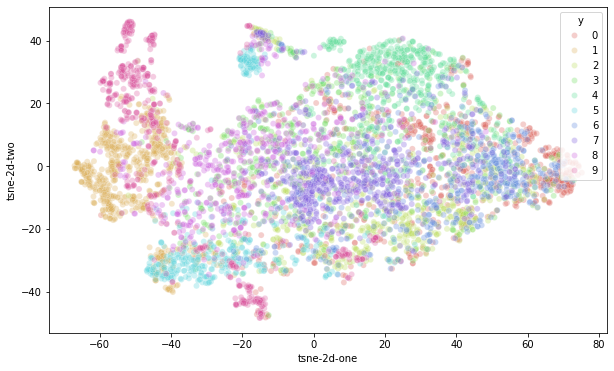

In [18]:
import seaborn as sns
plot_tsne(model2.encoder_q, test_dataset, test_loader, args)

t-SNE after loading pretrained weights

Feature extracting: 100%|██████████| 22/22 [00:01<00:00, 17.65it/s]


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5400 samples in 0.001s...
[t-SNE] Computed neighbors for 5400 samples in 0.275s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5400
[t-SNE] Computed conditional probabilities for sample 2000 / 5400
[t-SNE] Computed conditional probabilities for sample 3000 / 5400
[t-SNE] Computed conditional probabilities for sample 4000 / 5400
[t-SNE] Computed conditional probabilities for sample 5000 / 5400
[t-SNE] Computed conditional probabilities for sample 5400 / 5400
[t-SNE] Mean sigma: 0.279035
[t-SNE] KL divergence after 250 iterations with early exaggeration: 85.533264
[t-SNE] KL divergence after 1000 iterations: 2.101765
t-SNE done! Time elapsed: 23.32056164741516 seconds


23.32056164741516

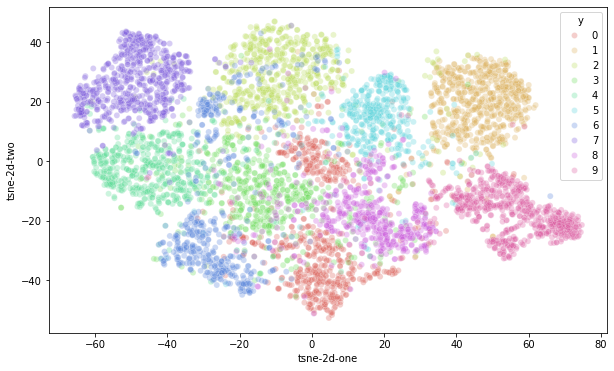

In [19]:
checkpoint = torch.load(args.results_dir + '/model_last.pth', map_location=device)
model2.load_state_dict(checkpoint['state_dict'])
plot_tsne(model2.encoder_q, test_dataset, test_loader, args)

***After pretraining, the learned representations can be well clustered into the 10 classes without knowing the labels.***

## Stage 2: transfer learning

We now transfer the pretrained model to the supervised downstream task, in this notebook EuroSAT scene classification. To highlight the benefit of self-supervised pretraining with unlabeled data, we assume only 10% of the training labels are available in the downstream task.

We will conduct both non-parametric KNN classification, and parametric linear probing.

### 1. KNN classification

In this section, we train a K-Nearest-Neighbour classifier with the features encoded by the pretrained model.

KNN is a non-parametric, supervised learning classifier, which uses proximity to make classifications about the grouping of an individual data point. It works by the following:
- Given a new test sample, calculate the distance between the sample and all other samples in the training set;
- Selects the 'k' training data samples that are closest to the new test sample;
- Assign the new data point to the class that has the majority among its 'k' nearest neighbors.

Define KNN and test function

In [20]:
# test using a knn monitor
def test_knn(net, memory_data_loader, test_data_loader, epoch, args):
    net.eval()
    classes = len(memory_data_loader.dataset.classes)
    total_top1, total_top5, total_num, feature_bank = 0.0, 0.0, 0, []
    with torch.no_grad():
        # generate feature bank
        for data, target in tqdm(memory_data_loader, desc='Feature extracting'):
            feature = net(data.to(device))
            feature = F.normalize(feature, dim=1)
            feature_bank.append(feature)
        # [D, N]
        feature_bank = torch.cat(feature_bank, dim=0).t().contiguous()
        # [N]
        feature_labels = torch.tensor(memory_data_loader.dataset.targets, device=feature_bank.device)
        # loop test data to predict the label by weighted knn search
        test_bar = tqdm(test_data_loader)
        for data, target in test_bar:
            data, target = data.to(device), target.to(device)
            feature = net(data)
            feature = F.normalize(feature, dim=1)

            pred_labels = knn_predict(feature, feature_bank, feature_labels, classes, args.knn_k, args.knn_t)

            total_num += data.size(0)
            total_top1 += (pred_labels[:, 0] == target).float().sum().item()
            test_bar.set_description('Test Epoch: [{}/{}] Acc@1:{:.2f}%'.format(epoch, args.epochs, total_top1 / total_num * 100))

    return total_top1 / total_num * 100

# knn monitor as in InstDisc https://arxiv.org/abs/1805.01978
# implementation follows http://github.com/zhirongw/lemniscate.pytorch and https://github.com/leftthomas/SimCLR
def knn_predict(feature, feature_bank, feature_labels, classes, knn_k, knn_t):
    # compute cos similarity between each feature vector and feature bank ---> [B, N]
    sim_matrix = torch.mm(feature, feature_bank)
    # [B, K]
    sim_weight, sim_indices = sim_matrix.topk(k=knn_k, dim=-1)
    # [B, K]
    sim_labels = torch.gather(feature_labels.expand(feature.size(0), -1), dim=-1, index=sim_indices)
    sim_weight = (sim_weight / knn_t).exp()

    # counts for each class
    one_hot_label = torch.zeros(feature.size(0) * knn_k, classes, device=sim_labels.device)
    # [B*K, C]
    one_hot_label = one_hot_label.scatter(dim=-1, index=sim_labels.view(-1, 1), value=1.0)
    # weighted score ---> [B, C]
    pred_scores = torch.sum(one_hot_label.view(feature.size(0), -1, classes) * sim_weight.unsqueeze(dim=-1), dim=1)

    pred_labels = pred_scores.argsort(dim=-1, descending=True)
    return pred_labels

Build model

In [21]:
model3 = ModelMoCo(
        dim=args.moco_dim,
        K=args.moco_k,
        m=args.moco_m,
        T=args.moco_t,
        arch=args.arch,
        bn_splits=args.bn_splits,
        symmetric=args.symmetric,
    ).to(device)

Build a small downstream dataset with 10% training data and full testing data

In [22]:
train_dataset_all = torchvision.datasets.ImageFolder(root='EuroSAT/EuroSAT_RGB_train_test/train',transform=test_transform)
indices = np.arange(len(train_dataset_all))
train_indices, _ = train_test_split(indices,train_size=0.1,stratify=train_dataset_all.targets,random_state=42)
train_dataset = Subset(train_dataset_all,train_indices)
test_dataset = torchvision.datasets.ImageFolder(root='EuroSAT/EuroSAT_RGB_train_test/test',transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True, drop_last=True)
train_loader.dataset.classes = train_dataset_all.classes
train_loader.dataset.targets = np.array(train_dataset_all.targets)[train_indices]
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True, drop_last=False)

KNN without pretrained weights

In [23]:
test_acc_1 = test_knn(model3.encoder_q, train_loader, test_loader, epoch, args)

Test Epoch: [101/101] Acc@1:48.78%: 100%|██████████| 85/85 [00:01<00:00, 54.02it/s]


KNN with pretrained weights

In [24]:
checkpoint = torch.load(args.results_dir + '/model_last.pth', map_location=device)
model3.load_state_dict(checkpoint['state_dict'])
test_acc_1 = test_knn(model3.encoder_q, train_loader, test_loader, epoch, args)

Test Epoch: [101/101] Acc@1:88.20%: 100%|██████████| 85/85 [00:01<00:00, 54.16it/s]


***Pretraining boosts the KNN accuracy by a large margin.***

### 2. Linear probing

In this section, we conduct linear probing with the features encoded by the pretrained model.

Linear probing is simply training a linear classifier (a linear layer outputing class logits) on top of the frozen pretrained backbone.


Build the supervised model, which appends one linear classification layer on top of the base encoder.

In [25]:
# build base encoder
model4 = ModelBase(feature_dim=args.moco_dim, arch=args.arch)
# append classification layer
model4.net[9] = nn.Sequential(
    model4.net[9],  # keep the existing last layer
    nn.Linear(args.moco_dim, 10)  # add a new layer that outputs 10 classes
)
#model4.net[9][1].weight.data.normal_(mean=0.0,std=0.01)
#model4.net[9][1].bias.data.zero_()

Build a small downstream dataset with 10% training data and full testing data

In [26]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(56,scale=(0.2,1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    #transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])
    ])
train_dataset_all = torchvision.datasets.ImageFolder(root='EuroSAT/EuroSAT_RGB_train_test/train',transform=train_transform)
indices = np.arange(len(train_dataset_all))
train_indices, _ = train_test_split(indices,train_size=0.1,stratify=train_dataset_all.targets,random_state=42)
train_dataset = Subset(train_dataset_all,train_indices)
test_dataset = torchvision.datasets.ImageFolder(root='EuroSAT/EuroSAT_RGB_train_test/test',transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4, pin_memory=True, drop_last=True)
#train_loader.dataset.targets = np.array(train_dataset_all.targets)[train_indices]
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True, drop_last=False)

Define train and test loop

In [27]:
# train for one epoch
def train_linear(net, data_loader, train_optimizer, epoch, args):
    net.train()
    adjust_learning_rate(optimizer, epoch, args)

    total_acc, total_loss, total_num, train_bar = 0.0, 0.0, 0, tqdm(data_loader)
    for img,target in train_bar:
        img, target = img.to(device), target.to(device)

        out = net(img)
        loss = criterion(out,target.long())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_num += data_loader.batch_size
        total_loss += loss.item() * data_loader.batch_size

        score = torch.sigmoid(out).detach().cpu()
        pred_labels = torch.argmax(score,axis=1)
        #average_precision = accuracy_score(target.cpu(), torch.argmax(score,axis=1)) * 100.0
        average_precision = (pred_labels == target.cpu()).float().sum().item()

        total_acc += average_precision

        train_bar.set_description('Train Epoch: [{}/{}], lr: {:.6f}, Loss: {:.4f}, Acc: {:.4f}'.format(epoch, args.epochs, optimizer.param_groups[0]['lr'], total_loss / total_num, total_acc / total_num))

    return total_loss / total_num, total_acc / total_num

# lr scheduler for training
def adjust_learning_rate(optimizer, epoch, args):
    """Decay the learning rate based on schedule"""
    lr = args.lr
    if args.cos:  # cosine lr schedule
        lr *= 0.5 * (1. + math.cos(math.pi * epoch / args.epochs))
    else:  # stepwise lr schedule
        for milestone in args.schedule:
            lr *= 0.1 if epoch >= milestone else 1.
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

# test
def test_linear(net, test_data_loader, epoch, args):
    net.eval()
    with torch.no_grad():
        test_bar = tqdm(test_data_loader)
        total_top1 = 0
        total_num = 0
        for img, target in test_bar:
            img, target = img.to(device), target.to(device)
            out = net(img)

            score = torch.sigmoid(out).detach().cpu()
            pred_labels = torch.argmax(score,axis=1)
            total_num += img.size(0)
            total_top1 += (pred_labels == target.cpu()).float().sum().item()
            test_bar.set_description('Test Epoch: [{}/{}] Acc@1:{:.2f}%'.format(epoch, args.epochs, total_top1 / total_num * 100))

    return total_top1 / total_num * 100

#### Supervised training from scratch for 10 epochs

In [28]:
model4.to(device)
criterion = torch.nn.CrossEntropyLoss()

args.lr = 0.1
args.epochs = 10
optimizer = torch.optim.SGD(model4.parameters(), lr=args.lr, momentum=0.9)

for epoch in range(0, args.epochs+1):
    train_loss = train_linear(model4, train_loader, optimizer, epoch, args)
    if epoch%5 == 0:
      test_acc_1 = test_linear(model4, test_loader, epoch, args)

Train Epoch: [0/10], lr: 0.100000, Loss: 2.6111, Acc: 0.1974: 100%|██████████| 33/33 [00:01<00:00, 25.32it/s]
Test Epoch: [0/10] Acc@1:11.54%: 100%|██████████| 85/85 [00:01<00:00, 53.40it/s]
Train Epoch: [1/10], lr: 0.097553, Loss: 2.2794, Acc: 0.2135: 100%|██████████| 33/33 [00:01<00:00, 25.20it/s]
Train Epoch: [2/10], lr: 0.090451, Loss: 1.9624, Acc: 0.2732: 100%|██████████| 33/33 [00:01<00:00, 25.63it/s]
Train Epoch: [3/10], lr: 0.079389, Loss: 1.8571, Acc: 0.3177: 100%|██████████| 33/33 [00:01<00:00, 26.23it/s]
Train Epoch: [4/10], lr: 0.065451, Loss: 1.7298, Acc: 0.3641: 100%|██████████| 33/33 [00:01<00:00, 26.08it/s]
Train Epoch: [5/10], lr: 0.050000, Loss: 1.6306, Acc: 0.4062: 100%|██████████| 33/33 [00:01<00:00, 25.84it/s]
Test Epoch: [5/10] Acc@1:40.06%: 100%|██████████| 85/85 [00:01<00:00, 54.66it/s]
Train Epoch: [6/10], lr: 0.034549, Loss: 1.5643, Acc: 0.4285: 100%|██████████| 33/33 [00:01<00:00, 26.10it/s]
Train Epoch: [7/10], lr: 0.020611, Loss: 1.4698, Acc: 0.4721: 100%|█

#### Linear probing with pretrained encoder for 10 epochs

In [29]:
## Load the pretrained weights

#checkpoint = torch.load(args.results_dir + '/model_last.pth', map_location=device)
checkpoint = torch.load('results/model_ep100.pth', map_location=device)
state_dict = checkpoint['state_dict']

for k in list(state_dict.keys()):
# retain only encoder up to before the embedding layer
  if k.startswith('encoder_q') and not k.startswith('encoder_k'):
    # remove prefix
    state_dict[k[len("encoder_q."):]] = state_dict[k]
# delete renamed or unused k
  del state_dict[k]

state_dict['net.9.0.weight'] = state_dict['net.9.weight']
state_dict['net.9.0.bias'] = state_dict['net.9.bias']
del state_dict['net.9.weight']
del state_dict['net.9.bias']
#state_dict = {k.replace("module.", ""): v for k,v in state_dict.items()}

msg = model4.load_state_dict(state_dict, strict=False)

assert set(msg.missing_keys) == {"net.9.1.weight", "net.9.1.bias"}

## Freeze the backbone and only train the last layer
for name, param in model4.named_parameters():
    if name not in ['net.9.1.weight','net.9.1.bias']:
        param.requires_grad = False
        
## Training
model4.to(device)
criterion = torch.nn.CrossEntropyLoss()

args.lr = 1
args.epochs = 10
optimizer = torch.optim.SGD(model4.parameters(), lr=args.lr, momentum=0.9)

for epoch in range(0, args.epochs+1):
    train_loss = train_linear(model4, train_loader, optimizer, epoch, args)
    if epoch%5 == 0:
      test_acc_1 = test_linear(model4, test_loader, epoch, args)

Train Epoch: [0/10], lr: 1.000000, Loss: 1.0686, Acc: 0.6553: 100%|██████████| 33/33 [00:00<00:00, 34.68it/s]
Test Epoch: [0/10] Acc@1:78.33%: 100%|██████████| 85/85 [00:01<00:00, 53.16it/s]
Train Epoch: [1/10], lr: 0.975528, Loss: 0.6935, Acc: 0.7704: 100%|██████████| 33/33 [00:00<00:00, 34.14it/s]
Train Epoch: [2/10], lr: 0.904508, Loss: 0.6562, Acc: 0.7770: 100%|██████████| 33/33 [00:00<00:00, 34.61it/s]
Train Epoch: [3/10], lr: 0.793893, Loss: 0.6793, Acc: 0.7609: 100%|██████████| 33/33 [00:00<00:00, 34.17it/s]
Train Epoch: [4/10], lr: 0.654508, Loss: 0.5933, Acc: 0.7950: 100%|██████████| 33/33 [00:00<00:00, 34.19it/s]
Train Epoch: [5/10], lr: 0.500000, Loss: 0.6141, Acc: 0.7860: 100%|██████████| 33/33 [00:00<00:00, 33.62it/s]
Test Epoch: [5/10] Acc@1:81.31%: 100%|██████████| 85/85 [00:01<00:00, 53.09it/s]
Train Epoch: [6/10], lr: 0.345492, Loss: 0.5828, Acc: 0.7992: 100%|██████████| 33/33 [00:00<00:00, 34.53it/s]
Train Epoch: [7/10], lr: 0.206107, Loss: 0.5660, Acc: 0.8087: 100%|█

***Linear probing with pretrained model outperforms supervised learning from scratch by a large margin.***

## Summary

Self-supervised pretraining helps boost downstream tasks in both accuracy and efficiency, especially in label-limited scenarios.